In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as cm
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit
import os
import wget
from bbpack import matplotlibrc

D:\ANU\ANACONDA\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Load in relevant data
file_path = './data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists(file_path):
    wget.download(
        url='https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits',
        out=file_path)

# Output as FITS table
table = Table.read('./data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')

# Linear fit to $A(O)$ against $R_{Gal}$

root-mean-square-error (rmse) = 0.0726462783112567
R-squared = 0.9125394692876643
Gradient = -0.034, Intercept = 9.128
Gradient_err = 1.480e-05, Intercept_err = 2.323e-04


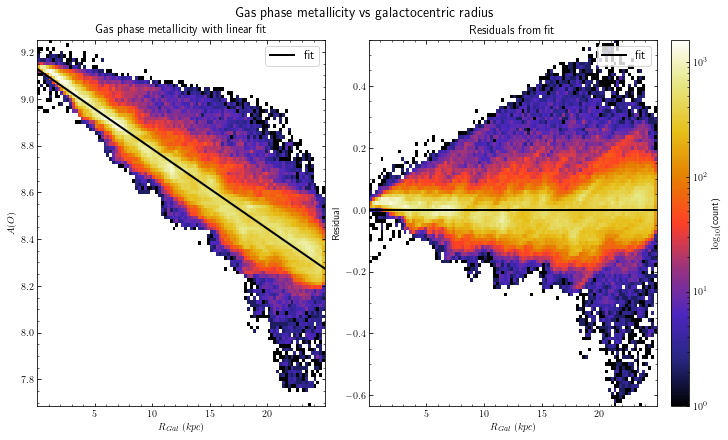

In [4]:
# Convert to Pandas dataframe
df = table.to_pandas()
df['radius'] = np.sqrt(df['x']**2+df['y']**2) # Compute R_Gal
df.sort_values(by='radius', inplace=True) # Sort values by R_Gal
df.reset_index(inplace=True)

# Compute variables
R_Gal = df['radius']
A_O = df['A_O']

# Fit to data and residuals
p, V = np.polyfit(R_Gal, A_O, deg=1, cov=True)

fit = (p[0])*R_Gal+(p[1])
p_1_err, p_2_err = np.sqrt(np.diag(V))
residuals = A_O-fit

dof = len(fit)-len(p)
rmse = np.sqrt(1/dof*np.sum((residuals)**2))
R_squared = 1-np.sum(residuals**2)/(np.var(A_O)*len(A_O))
print(f'root-mean-square-error (rmse) = {rmse}')
print(f'R-squared = {R_squared}')

# Print fit parameters and covariance parameters
print(f'Gradient = {p[0]:.3f}, Intercept = {p[1]:.3f}')
print(f'Gradient_err = {np.sqrt(np.diag(V)[0]):.3e}, Intercept_err = {np.sqrt(np.diag(V)[1]):.3e}')

# Create plot
fig, ax = plt.subplots(1, 2, figsize = (10,6), constrained_layout=True)
ax1 = ax[0]
ax2 = ax[1]

# Cmap and bin choice
norm = cm.colors.LogNorm()
cmap = 'CMRmap'
bins = 100

# Panel 1
h1 = ax1.hist2d(R_Gal, A_O, bins=bins, norm=norm, cmap=cmap)
ax1.plot(R_Gal, fit, linewidth = 2, label = 'fit')
ax1.fill_between(R_Gal, fit-(p_1_err*R_Gal+p_2_err), fit+(p_1_err*R_Gal+p_2_err), alpha = 0.7)
ax1.set_xlabel(r'$R_{Gal}\;(kpc)$')
ax1.set_ylabel(r'$A(O)$')
ax1.set_title(r'Gas phase metallicity with linear fit')
ax1.legend()

cbar = plt.colorbar(h1[-1], ax=ax2, label=r'$\log_{10}$(count)')

# Panel 2
ax2.hist2d(R_Gal, A_O-fit, bins=bins, cmap=cmap, norm=norm)
ax2.axhline(0, linewidth = 2, label = 'fit')
ax2.fill_between(R_Gal, 0-(p_1_err*R_Gal+p_2_err), 0+(p_1_err*R_Gal+p_2_err), alpha = 0.7)
ax2.set_xlabel(r'$R_{Gal}\;(kpc)$')
ax2.set_ylabel(r'Residual')
ax2.set_title(r'Residuals from fit')
ax2.legend()

# Figure parameters
fig.suptitle(r'Gas phase metallicity vs galactocentric radius', fontsize = 14)
plt.savefig('./figures/R_Gal vs A(O).png')
plt.show()

In [5]:
# Checking regions of larger residual

mask = (R_Gal > 10) & (R_Gal < 20) # Masking for R_Gal values with largest residuals

dof = len(fit[mask])-len(p)
rmse = np.sqrt(1/dof*np.sum(residuals[mask]**2))
R_squared = 1-np.sum(residuals[mask]**2)/(np.var(A_O[mask])*len(A_O[mask]))
print(f'root-mean-square-error (rmse) = {rmse}')
print(f'R-squared = {R_squared}')

root-mean-square-error (rmse) = 0.08050159034756507
R-squared = 0.6117805345482643


## Comments on linear fit

The linear fit to $\text{A(O)}$ describes the overall trend of the data well, however, for $R_{Gal} > 5$ in particular, the scatter from the fit is large, and the quality of the fit decreases significantly on smaller scales. We quantify the quality of the general fit and regions of large scatter using the root-mean-squared-error (RMSE) and $R^2$ parameters above.

# 2D histograms of median $\text{A(O)}$

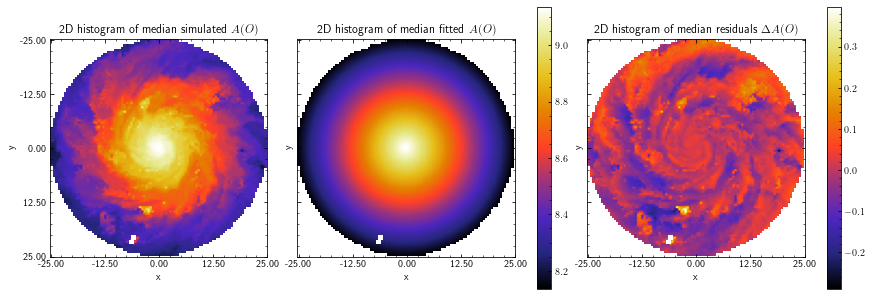

In [6]:
from scipy.stats import binned_statistic_2d
# Define position variables from dataframe
x = df['x']
y = df['y']
z = df['z']

# Create 2D histograms, taking median A_O value in each bin
stat1, x_edges1, y_edges1, binN1 = binned_statistic_2d(x, y, A_O, statistic='median', bins=bins)
stat2, x_edges2, y_edges2, binN2 = binned_statistic_2d(x, y, fit, statistic='median', bins=bins)

kpcperbin = 50/bins

def plot_2D_median_AO(stat1, stat2, name):
    # Create subfigures
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)
    
    # Organising ticks
    tick = np.linspace(0,stat1.shape[0],5)
    ticklabel = (tick-stat1.shape[0]//2)*kpcperbin

    # Panel 1
    im1=ax1.imshow(stat1, cmap=cmap)
    ax1.set_xticks(tick, (format(i, '.2f') for i in ticklabel))
    ax1.set_yticks(tick, (format(i, '.2f') for i in ticklabel))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(r'2D histogram of median simulated $A(O)$')

    # Panel 2
    im2=ax2.imshow(stat2, cmap=cmap)
    ax2.set_xticks(tick, (format(i, '.2f') for i in ticklabel))
    ax2.set_yticks(tick, (format(i, '.2f') for i in ticklabel))
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title(r'2D histogram of median fitted $A(O)$')

    # Panel 3
    im3=ax3.imshow(stat1-stat2, cmap=cmap)
    ax3.set_xticks(tick, (format(i, '.2f') for i in ticklabel))
    ax3.set_yticks(tick, (format(i, '.2f') for i in ticklabel))
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title(r'2D histogram of median residuals $\Delta A(O)$')

    # Colorbar
    plt.colorbar(im1, ax=ax2)
    plt.colorbar(im3, ax=ax3)
    
    # Show
    plt.savefig('./figures/2D_median_A(O)_'+name+'.png')
    plt.show()

plot_2D_median_AO(stat1=stat1, stat2=stat2, name='1')

## Discussing bin count and analysis quality    

We have chosen 100 bins in both the $x$ and $y$ axes to map the 2D distribution of the median gas phase metallicity. This appears to be a sweet spot for the number of bins for this dataset. Fewer bins will reduce the resolution of the output, producing a blocky appearance with less defined contrast between high and low median $\text{A(O)}$.

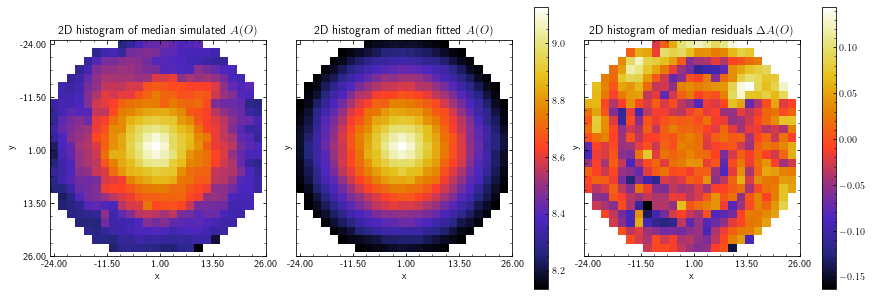

In [7]:
bins = 25
kpcperbin = 50/bins

stat1, x_edges1, y_edges1, binN1 = binned_statistic_2d(x, y, A_O, statistic='median', bins=bins)
stat2, x_edges2, y_edges2, binN2 = binned_statistic_2d(x, y, fit, statistic='median', bins=bins)

plot_2D_median_AO(stat1=stat1, stat2=stat2, name='2')

However, we also want to avoid to high a bin count. Although we gain resolution as we approach the noise floor of the data, certain 2D bins will have no value associated to them, and hence the median of those bins will return nothing. This results in white regions of no data forming in our analysis of the median $\text{A(O)}$ distribution.

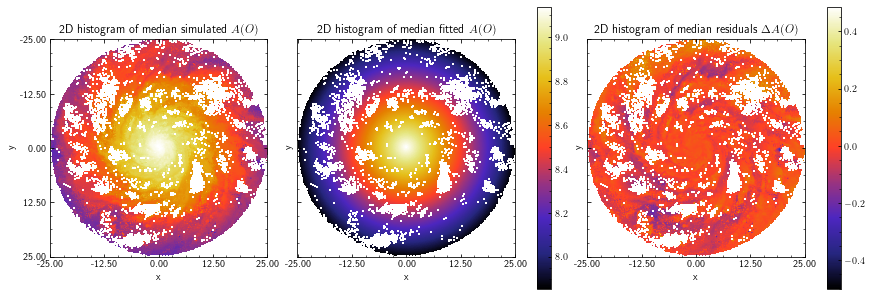

In [8]:
bins = 300
kpcperbin = 50/bins

stat1, x_edges1, y_edges1, binN1 = binned_statistic_2d(x, y, A_O, statistic='median', bins=bins)
stat2, x_edges2, y_edges2, binN2 = binned_statistic_2d(x, y, fit, statistic='median', bins=bins)

plot_2D_median_AO(stat1=stat1, stat2=stat2, name='3')

A good middle-ground for bin number choice is to have a smooth distribution of median $\text{A(O)}$ over the simulation space, as to best represent the distribution without having distracting white regions where zero data is present.

## Discussing Residuals

As shown in the 1D case, the linear fit over the 2D median $\text{A(O)}$ works well to describe the underlying distribution of $\text{A(O)}$ throughout the simulated galaxy. However, the residuals show evidence that the linear model does not account for some complexity in the galaxy, resulting in under / over subtraction evident in the residuals. Given the simulation models a Milky Way galaxy analogue, it is clear that the regions of complexity are the spiral arms of the galaxy, where changes in the gas phase metallicity are not explained by a linear fit.